In [1]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import model_from_json
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from model_select_func import save_model, load_model, record_results, avg_image

In [2]:
np.random.seed(123) # set random seed for reproducability

In [3]:
tf.get_logger().setLevel('ERROR') # hide some warning messages

#### Load Test Datasets

In [4]:
original_split_data_path='../0. Project Data/Original Split Data'
reshaped_and_padded_data_path='../0. Project Data/Reshaped zero-padded and split data'

#### Image Parameters

In [5]:
#original data parameters
org_batch_size = 32
org_img_height = 180
org_img_width = 180
org_img_channels = 3

# padded image parameters
padded_batch_size = 32
padded_img_height = 256
padded_img_width = 256
padded_img_channels = 3

In [6]:
# tf.data dataset of original test data
org_test_ds = image_dataset_from_directory(
    original_split_data_path + '/test',
    image_size=(org_img_width, org_img_height),
    batch_size=org_batch_size,
    shuffle=False,)
# tf.data dataset of padded test data
padded_test_ds = image_dataset_from_directory(
    reshaped_and_padded_data_path + '/test',
    image_size=(padded_img_width, padded_img_height),
    batch_size=padded_batch_size,
    shuffle = False)

Found 843 files belonging to 4 classes.
Found 843 files belonging to 4 classes.


In [7]:
model_dir=['Model 1-Original Data', 'Model 2-Zero-padded Data Model',
           'Model 3-Zero-padded Data Transfer Learning Model']+[
    'Models 4.x-Transfer Learning Hyperparameter Tuning Zero-padded Data Model/' + str(i+1) for i in range(5)]
model_dir

['Model 1-Original Data',
 'Model 2-Zero-padded Data Model',
 'Model 3-Zero-padded Data Transfer Learning Model',
 'Models 4.x-Transfer Learning Hyperparameter Tuning Zero-padded Data Model/1',
 'Models 4.x-Transfer Learning Hyperparameter Tuning Zero-padded Data Model/2',
 'Models 4.x-Transfer Learning Hyperparameter Tuning Zero-padded Data Model/3',
 'Models 4.x-Transfer Learning Hyperparameter Tuning Zero-padded Data Model/4',
 'Models 4.x-Transfer Learning Hyperparameter Tuning Zero-padded Data Model/5']

In [8]:
model_names = ['Base CNN Org Data', 'Base CNN Zero-Pad', 'Transfer Learning Zero-Pad',
               'Hypermodel1 Zero-Pad', 'Hypermodel2 Zero-Pad', 'Hypermodel3 Zero-Pad', 
               'Hypermodel4 Zero-Pad', 'Hypermodel5 Zero-Pad']
dataset = ['Org', 'Zero-Pad', 'Zero-Pad', 'Zero-Pad', 'Zero-Pad', 'Zero-Pad', 'Zero-Pad', 'Zero-Pad']
model_dict = {'Model Directories':model_dir, 'Model Name':model_names, 'Dataset':dataset}
model_frame=pd.DataFrame(model_dict)
model_frame

,Model Directories,Model Name,Dataset
0,Model 1-Original Data,Base CNN Org Data,Org
1,Model 2-Zero-padded Data Model,Base CNN Zero-Pad,Zero-Pad
2,Model 3-Zero-padded Data Transfer Learning Model,Transfer Learning Zero-Pad,Zero-Pad
3,Models 4.x-Transfer Learning Hyperparameter Tu...,Hypermodel1 Zero-Pad,Zero-Pad
4,Models 4.x-Transfer Learning Hyperparameter Tu...,Hypermodel2 Zero-Pad,Zero-Pad
5,Models 4.x-Transfer Learning Hyperparameter Tu...,Hypermodel3 Zero-Pad,Zero-Pad
6,Models 4.x-Transfer Learning Hyperparameter Tu...,Hypermodel4 Zero-Pad,Zero-Pad
7,Models 4.x-Transfer Learning Hyperparameter Tu...,Hypermodel5 Zero-Pad,Zero-Pad


#### Score Models Using Test Data

In [9]:
scores=[]
for index, row in model_frame.iterrows():
    if row[2]=='Org':
        scores.append(record_results(load_model(row[0]), row[1], org_test_ds))
    elif row[2]=='Zero-Pad':
        scores.append(record_results(load_model(row[0]), row[1], padded_test_ds))
    #break
    
results= pd.DataFrame(scores, columns=['Model Name', 'f1 score', 'test_acc', 'precision', 'recall'])

Loaded Model 1-Original Data from disk
27/27 [==============================] - 2s 26ms/step
Loaded Model 2-Zero-padded Data Model from disk
27/27 [==============================] - 2s 38ms/step
Loaded Model 3-Zero-padded Data Transfer Learning Model from disk
27/27 [==============================] - 13s 261ms/step
Loaded Models 4.x-Transfer Learning Hyperparameter Tuning Zero-padded Data Model/1 from disk
27/27 [==============================] - 4s 155ms/step
Loaded Models 4.x-Transfer Learning Hyperparameter Tuning Zero-padded Data Model/2 from disk
27/27 [==============================] - 4s 149ms/step
Loaded Models 4.x-Transfer Learning Hyperparameter Tuning Zero-padded Data Model/3 from disk
27/27 [==============================] - 4s 150ms/step
Loaded Models 4.x-Transfer Learning Hyperparameter Tuning Zero-padded Data Model/4 from disk
27/27 [==============================] - 4s 153ms/step
Loaded Models 4.x-Transfer Learning Hyperparameter Tuning Zero-padded Data Model/5 from dis

In [10]:
results

,Model Name,f1 score,test_acc,precision,recall
0,Base CNN Org Data,0.884659,0.884935,0.891853,0.884935
1,Base CNN Zero-Pad,0.912197,0.911032,0.913947,0.911032
2,Transfer Learning Zero-Pad,0.897770,0.900356,0.901016,0.900356
3,Hypermodel1 Zero-Pad,0.933480,0.934757,0.933673,0.934757
4,Hypermodel2 Zero-Pad,0.926688,0.927639,0.927554,0.927639
5,Hypermodel3 Zero-Pad,0.901339,0.902728,0.910586,0.902728
6,Hypermodel4 Zero-Pad,0.913846,0.913405,0.914549,0.913405
7,Hypermodel5 Zero-Pad,0.909529,0.909846,0.914791,0.909846


#### Model Selection

Based on the scoring chart above, we can see that the Hypermodel 1 using Zero-Padded data outperforms all other models in all metrics.

In [11]:
HyperModel1=load_model('Models 4.x-Transfer Learning Hyperparameter Tuning Zero-padded Data Model/1')

Loaded Models 4.x-Transfer Learning Hyperparameter Tuning Zero-padded Data Model/1 from disk


In [12]:
HyperModel1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 256, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0   

This model was built using the convolutional base of the pre-trained VGG16 model ontop of which a densely connected layer, a drop out layer and classification layer reside. The convolutional base consists of a conv, conv, pooling stacked pyramidial architecture as shown below:

In [13]:
conv_base = keras.applications.vgg16.VGG16(
 weights='imagenet',
 include_top=False)
conv_base.trainable = False # freeze weights
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

The number of nodes in the densely connected layer as well as the dropout percentage were choosen empirically through hyperparameter tuning. The winning model had hyperparameters of 128  nodes in the densely connected layer and a dropout percentage of 50%. This model was then trained on zero-padded data before final evaluation.

#### Confusion Matrix of Winning Model on Test Data

In [14]:
true_labels = []
for images, labels in padded_test_ds:
    true_labels.extend(labels.numpy())
y_pred_probas = HyperModel1.predict(padded_test_ds)
y_pred_labels = np.argmax(y_pred_probas, axis = 1)
cm=confusion_matrix(true_labels, y_pred_labels)

27/27 [==============================] - 4s 151ms/step


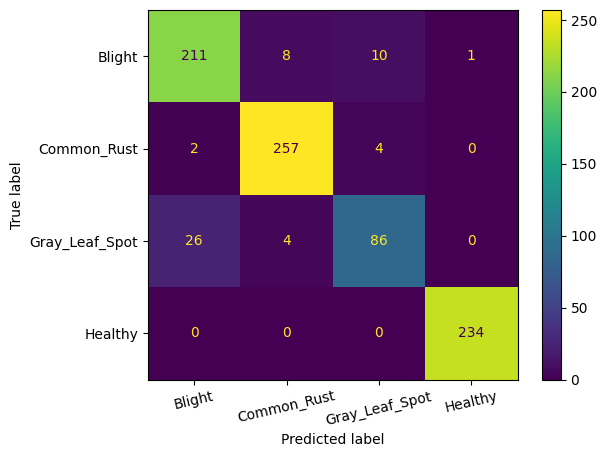

In [15]:
disp=ConfusionMatrixDisplay(confusion_matrix= cm,
                            display_labels=padded_test_ds.class_names)
disp.plot(xticks_rotation= 13)
plt.show()

From the confusion matrix of the test data, we can see that the majority of the misclassifications are between the disease classes of Blight, Common_Rust, and Gray_Leaf_Spot. Some of this could be due to misclassification of the true labels due to human error when constructing the dataset. 

The worse predicted class was Gray_Leaf_Spot with 22% of its images being misclassified as Blight and 3% being misclassified as Common_Rust. This is probably due to the class imbalance where there exists a 0.27, 0.31, 0.14, 0.28 proportion between the Blight, Common_Rust, Gray_Leaf_Spot, Healthy classes respectively. With Gray_Leaf_Spot having half as many instances as the other class, the model we created which optimized based on accuracy, didn't value misclassifying Gray_Leaf_Spot as much as the other classes. 

The true Healthy class instances were all predicted correctly with only 1 Blight image being misclassified as Healthy. This makes sense as we can see from the average class images shown below, there is a distinct visual separation between the Healthy and diseased classes

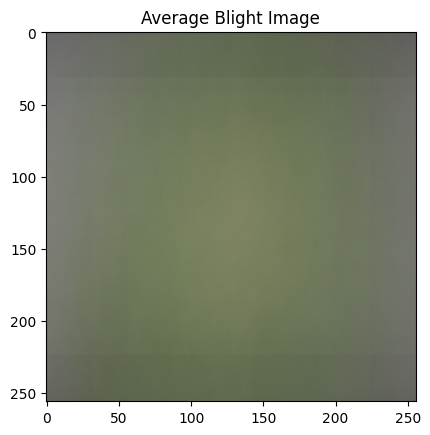

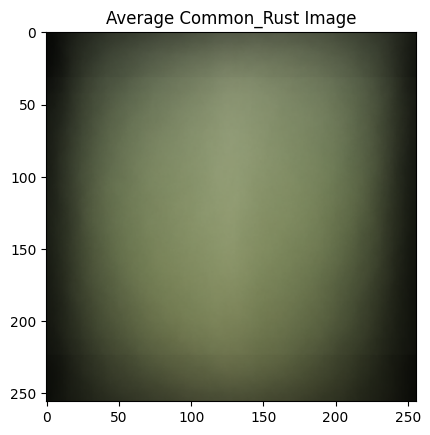

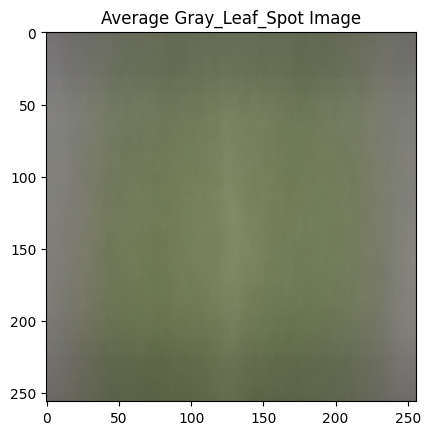

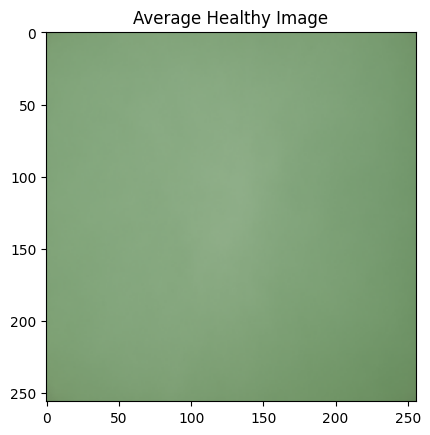

In [16]:
padded_path = '../0. Project Data/Reshaped and zero-padded Data/'
padded_dir = pathlib.Path(padded_path).with_suffix('')
for class_ in ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']:
    avg_image(class_, padded_dir)

Let us see the Blight image that was misclassified as Healthy

In [17]:
label_dict = {'true_labels':true_labels, 'pred_labels':y_pred_labels}
label_df = pd.DataFrame(label_dict)
label_df.head()

,true_labels,pred_labels
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [18]:
#Image 154 was from the Blight class but misclassified as Healthy
label_df[(label_df['true_labels']!=label_df['pred_labels']) & (label_df['pred_labels']==3)]

,true_labels,pred_labels
154,0,3


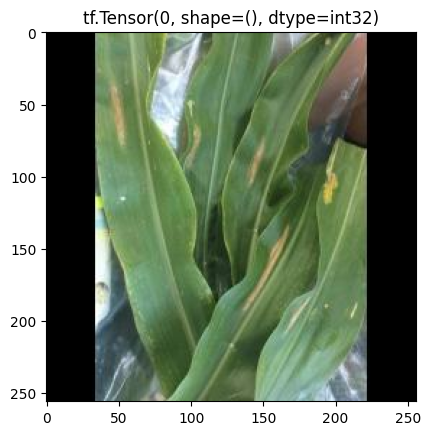

In [19]:
counter=0
for batch, labels in padded_test_ds:
    for i in range(len(batch)):
        if counter != 154: #
            counter+=1
            continue
        counter+=1
        # Convert the image tensor to numpy array
        image_np = batch[i].numpy()
        # Round due to bilinear interpolation
        image_np = np.round(image_np).astype(int)
        # Display the image using Matplotlib
        plt.imshow(image_np)
        plt.title(str(labels[i]))
        plt.show()

The above Blight image being misclassified as Healthy is understandable; there are only a few slight miscolorations on the leaves while the majority of the surface area is a lush green.

If our classification goal was simplified to identifying diseased vs healthy corn leaves, our current model would have 99.88% accuracy